## 7. 인물사진을 만들어 보자

피사계 심도(depth of field, DOF)는 사진술에서 한 사진의 초점이 맞은 것으로 인식되는 범위이다. 렌즈의 초점은 단 하나의 면에 정해지게 되어 있으나 실제 사진에서는 초점면을 중심으로 서서히 흐려지는 현상이 나타나는데, 이때 충분히 초점이 맞은 것으로 인식되는 범위의 한계를 피사계 심도라 한다.

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다. 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.

따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.

배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
블러링(blurring) 기술로 배경을 흐리게 합니다.
피사체를 배경의 원래 위치에 합성합니다.

세그멘테이션(Segmentation)이 뭔가요?

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

시맨틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법 

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

urllib는 웹에서 데이터를 다운로드할 때 사용

cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요

pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

(960, 724, 3)


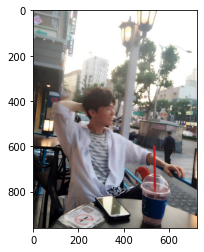

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Lee.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
먼저 PixelLib에서 제공해 주는 모델을 다운로드합니다.

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f0a9c4f64c0>)

다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

In [11]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [10]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

PASCAL VOC 데이터의 라벨 종류

In [12]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [ ]:
우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.

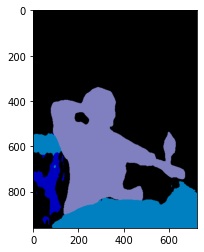

In [13]:
plt.imshow(output)
plt.show()

In [14]:
segvalues

{'class_ids': array([ 0,  9, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [15]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. 

segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

- 아래 코드를 이해하지 않아도 좋습니다
- PixelLib에서 그대로 가져온 코드입니다
- 주목해야 할 것은 생상 코드 결과물이예요!

In [16]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [17]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [18]:
seg_color = (128,128,192)

이제 seg_color로만 이루어진 마스크를 만들어 봅시다.

(960, 724)


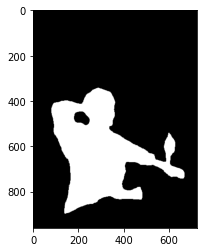

In [19]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같네요.

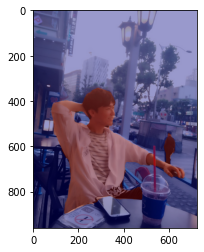

In [20]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 셸로우 포커스 만들기 (4) 배경 흐리게 하기

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

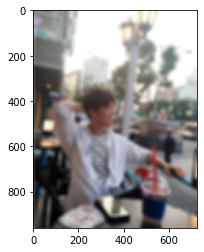

In [27]:
# (13,13)은 blurring kernel size를 뜻합니다 # 더 흐리게 하기 위해 20으로 했음
# 다양하게 바꿔보세요

img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

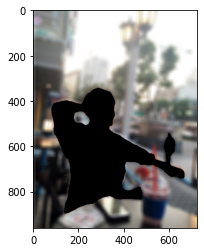

In [28]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

### 7-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

img_concat = np.where(img_mask_color==0, img_bg_blur, img_orig) 이렇게 사용가능! 

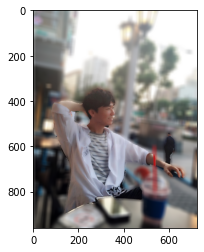

In [33]:
img_concat = np.where(img_mask_color==255, img_orig , img_bg_blur)   #  np.where 조건문 공부하기 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 7-7. 프로젝트: 인물 모드 문제점 찾기
만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

우선 주요 라이브러리 버전을 확인해 볼까요?

In [35]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1
